# Фундаментальная ошибка валидации или решение задачи

Помимо непосредственно вошедшего в финальный результат кода, моделей и выбранных параметров здесь содержатся некоторые не нашедшие применения идеи.

In [1]:
import os

# Путь к корневой директории, если ноутбук запускался не из неё
PATH = "D:\\Documents\\GitHub\\medical-imaging-evaluation"
# Путь к папке с данными
DATA_PATH = "D:\\Documents\\GitHub\\medical-imaging-evaluation\\data"
os.chdir(PATH)

In [43]:
import cv2
import joblib
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVR, SVC
from sklearn.cluster import DBSCAN
from sklearn.metrics import jaccard_score, mean_absolute_error
from sklearn.feature_selection import SelectFromModel

from model.metrics.metrics_wrapper import Metrics
from model.metrics.metrics_table import TableMetricsCalculator

sns.set()

In [3]:
# Таблицы с верными значениями оценки
train_eval = pd.read_csv(DATA_PATH + '/OpenPart.csv')
test_eval = pd.read_csv(DATA_PATH + '/SecretPart_dummy.csv')

# Имена исходных изображений
train_names = train_eval['Case'].to_numpy()
test_names = test_eval['Case'].to_numpy()

# Разбиение train на обучающую и валидационную выборки
val_size = 20

val_indices = np.random.choice(train_names.shape[0], val_size, replace=False)
train_indices = [i for i in range(len(train_names)) if i not in val_indices]

val_names = train_names[val_indices]
train_names = train_names[train_indices]

val_label = train_eval.iloc[val_indices]
train_label = train_eval.iloc[train_indices]

print('train size =', len(train_names))
print('validation size =', len(val_names))

def load_data(names, folder, ending):
    """
    Загрузка необходимых изображений (имена в списке names) из указанной папки.
    """
    data = []
    for name in names:
        image = cv2.imread(folder + '/' + name.split('.')[0] + ending + '.png', 0)
        data.append(image)
    return np.array(data)

# Загрузка оцениваемых разметок
train_data = [
    load_data(train_names, DATA_PATH + '/sample_1', '_s1'),
    load_data(train_names, DATA_PATH + '/sample_2', '_s2'),
    load_data(train_names, DATA_PATH + '/sample_3', '_s3')
]

val_data = [
    load_data(val_names, DATA_PATH + '/sample_1', '_s1'),
    load_data(val_names, DATA_PATH + '/sample_2', '_s2'),
    load_data(val_names, DATA_PATH + '/sample_3', '_s3')
]

test_data = [
    load_data(test_names, DATA_PATH + '/sample_1', '_s1'),
    load_data(test_names, DATA_PATH + '/sample_2', '_s2'),
    load_data(test_names, DATA_PATH + '/sample_3', '_s3')
]

# Загрузка экспертной разметки
expert_train = load_data(train_names, DATA_PATH + '/expert', '_expert')
expert_val = load_data(val_names, DATA_PATH + '/expert', '_expert')
expert_test = load_data(test_names, DATA_PATH + '/expert', '_expert')

train size = 45
validation size = 15


Проверим корректность загрузки данных.

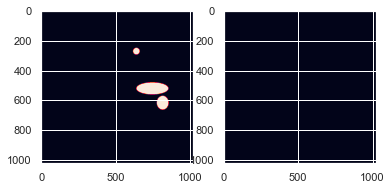

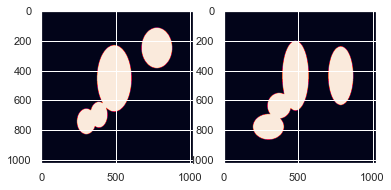

In [6]:
for i in range(2):
    plt.subplot(1, 2, 1)
    plt.imshow(test_data[0][i])
    plt.subplot(1, 2, 2)
    plt.imshow(expert_test[i])
    plt.show()

## Кластеризация (не вошла в финальное решение)

In [221]:
def convert_to_table(img):
    """
    Преобразование изображения в список пар (i, j) -- индексов пикселей, содержащихся в разметке.
    """
    elements = []
    for i in range(len(img)):
        for j in range(len(img[i])):
            if img[i][j] > 0:
                elements.append([i, j])
    return pd.DataFrame(elements)

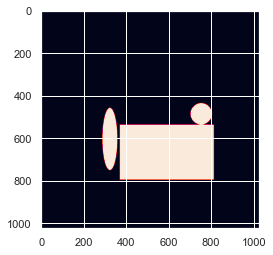

In [190]:
plt.imshow(expert_train[1])

Так как количество кластеров различается для каждого изображения, здесь удобно использовать DBSCAN:

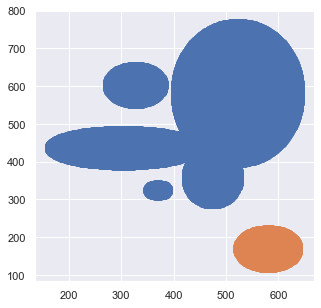

In [311]:
dbscan = DBSCAN(eps=40)
pred = dbscan.fit_predict(img_table)
plt.figure(figsize=(5,5))
for cl in np.unique(pred):
    cl_inds = [i for i in range(len(pred)) if pred[i] == cl]
    plt.scatter(img_table[0].iloc[cl_inds], img_table[1].iloc[cl_inds])
plt.show()

Изначальной целью было построение кластеров и выпуклой оболочки по всем точкам каждого кластера для удаления шумов и выявления более общих областей в случае наличия большого количество точек в непосредственной близости. Однако визуальный анализ данных показал, что такой способ не подходит для текущего датасета, однако он всё ещё может быть полезен в случае попиксельной разметки.

## Подсчёт метрик и построение модели

In [4]:
class RoundRegressor(BaseEstimator, RegressorMixin):
    """
    Округление значений, полученных в результате работы выбранной модели регрессии.
    """
    def __init__(self, model, round_model=True):
        self.model = model
        self.round_model = round_model
        
    def fit(self, X, y):
        self.model.fit(X, y)
        return self
    
    def predict(self, X):
        pred = self.model.predict(X)
        if self.round_model:
            pred = np.round(pred, 0).astype(int)
        return pred
    

class RoundClassifier(BaseEstimator, ClassifierMixin):
    """
    Аналогичный RoundRegressor класс, однако является классификатором.
    """
    def __init__(self, model, round_model=True):
        self.model = model
        self.round_model = round_model
        
    def fit(self, X, y):
        self.model.fit(X, y)
        return self
    
    def predict(self, X):
        pred = self.model.predict(X)
        if self.round_model:
            pred = np.round(pred, 0).astype(int)
        return pred

### Простейшая модель с одной метрикой
Для построения решения-бейзлайна для дальнейшего сравнения с ним используется единственная метрика jaccard_score.

In [7]:
def make_dataframe_jaccard_score(expert, predicted):
    """
    Создаёт датафрейм с jaccard_score как единственным признаком.
    """
    data = []
    for i in range(len(expert)):
        row = [jaccard_score((expert[i].reshape(1, -1)[0] > 0).astype(int), (predicted[i].reshape(1, -1)[0] > 0).astype(int))]
        data.append(np.array(row))
    return pd.DataFrame(data)


base_df = pd.concat([
    make_dataframe_jaccard_score(expert_train, train_data[0]).fillna(-1),
    make_dataframe_jaccard_score(expert_train, train_data[1]).fillna(-1),
    make_dataframe_jaccard_score(expert_train, train_data[2]).fillna(-1)
])

labels = pd.concat([train_label['Sample 1'], train_label['Sample 2'], train_label['Sample 3']])

scaler = StandardScaler()
base_df = scaler.fit_transform(base_df)

models = [LinearRegression(), RandomForestRegressor(), RandomForestClassifier(), GradientBoostingClassifier(),
          KNeighborsRegressor(), KNeighborsClassifier(), SVC(), SVR(),
         GaussianNB(), LogisticRegression()]

# Стратифицированная кросс-валидация по трём фолдам
skf = StratifiedKFold(n_splits=3)
for model in models:
    print(model, end=': ')
    rounded = cross_validate(estimator=RoundRegressor(model), X=base_df, y=labels,
                   scoring='neg_mean_absolute_error', cv=skf)['test_score']
    print(rounded.mean())

C:\ProgramData\Anaconda3\envs\pytorch-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LinearRegression(): -0.8250000000000001
RandomForestRegressor(): -0.9583333333333334
RandomForestClassifier(): -0.9333333333333332
GradientBoostingClassifier(): -0.9333333333333332
KNeighborsRegressor(): -1.0416666666666667
KNeighborsClassifier(): -0.9
SVC(): -0.7083333333333334
SVR(): -0.7166666666666667
GaussianNB(): -0.8666666666666667
LogisticRegression(): -0.8583333333333334


### Большее количество метрик

Метрики реализованы на основе библиотеки https://github.com/deepmind/surface-distance. Помимо реализованных добавлены такие метрики, как Symmetric Surface Distance (средняя), Volume Overlap Error и Relative Volume Difference:

$$AvSD = \frac{1}{|X|+|Y|}\left(\sum D_Y(x)+\sum D_X(y)\right)$$

$$VOE = 100\times\left(1-2\frac{X\cap Y}{|X|+|Y|}\right)$$

$$RVD = \frac{2|X\cap Y|}{|X|+|Y|}$$

К метрикам, основанным на поиске разницы между изображениями, также добавлены метрики, основанные на табличных данных. Последние не подходят для работы с разметками другого вида, модели с их использованием рассмотрены в конце ноутбука.

In [5]:
def compute_metrics(ex, pred):
    """
    Подсчёт значения метрик для двух изображений -- экспертной и оцениваемой разметок.
    Метрики: на основе расстояний, на основе объёма множеств и на основе расположения геометрических фигур (опционально).
    """
    result = []
    num_metrics = 12
    
    result.append(ex.sum() / 255)
    result.append(pred.sum() / 255)
    
    if ex.sum() == 0 and pred.sum() == 0:
        return result + [0] * num_metrics
    elif ex.sum() == 0 or pred.sum() == 0:
        return result + [np.NaN] * num_metrics

    metrics = Metrics(ex, pred)
    result = metrics.compute_all()
    
    return result

def select_important_metrics(tabled):
    return [
        tabled['mean_min_center_distance_1to2_L2'],
        tabled['mean_min_center_distance_2to1_L2'],
        tabled['amax_min_center_distance_2to1_L2'],
    ]

def make_dataframe(expert, predicted, names=None):
    """
    Создание pd.DataFrame из метрик, рассчитанных для каждой пары объектов из выборок expert и predicted.
    """
    data = []
    
    if names is not None:
        tmc = TableMetricsCalculator(DATA_PATH + "\\" + names['csv'])
        for i in range(len(expert)):
            tabled = select_important_metrics(
                tmc.calc_table_metrics_for_image_pair(names['name'][i], names['set'][0], names['set'][1])
            )
            data.append(np.array(compute_metrics(expert[i], predicted[i]) + tabled))
    else:
        for i in range(len(expert)):
            data.append(np.array(compute_metrics(expert[i], predicted[i])))
            
    return pd.DataFrame(data)

In [6]:
def bootstrap(model, X, y, k=500):
    """
    Оценка работы модели на k случайных подвыборок (с возвращением) исходной выборки.
    В данном случае подходит больше кросс-валидации по фолдам из-за объёма данных.
    """
    scores = []
    
    for i in range(k):
        inds = np.random.choice(X[0].shape[0], 10, replace=False)
        not_inds = [i for i in range(X[0].shape[0]) if i not in inds]
        
        # Картинки отправляются в трейн и валидацию тройками (из каждого sample)
        train_df = np.concatenate([X[j][not_inds] for j in range(len(X))])
        test_df = np.concatenate([X[j][inds] for j in range(len(X))])
        
        scaler = StandardScaler()
        train_df = scaler.fit_transform(train_df)
        test_df = scaler.transform(test_df)
        
        train_labels = np.concatenate([np.array(y[j])[not_inds] for j in range(len(y))])
        test_labels = np.concatenate([np.array(y[j])[inds] for j in range(len(y))])
        
        model.fit(train_df, train_labels)
        scores.append(mean_absolute_error(model.predict(test_df), test_labels))
        
    return np.array(scores)

Загрузка и преобразование всей имеющейся обучающей выборки:

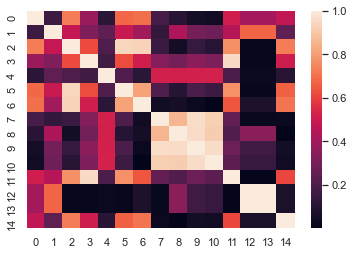

In [7]:
X = [
    make_dataframe(expert_train, train_data[0]),
    make_dataframe(expert_train, train_data[1]),
    make_dataframe(expert_train, train_data[2])
]

y = [
    train_label['Sample 1'],
    train_label['Sample 2'],
    train_label['Sample 3']
]

X_df = pd.concat(X)
X_df['label'] = np.concatenate(y)
X_df = StandardScaler().fit_transform(X_df)

sns.heatmap(pd.DataFrame(X_df).corr(method="spearman").abs())

for i in range(len(X)):
    X[i] = X[i].fillna(-1).to_numpy()

Корреляционная матрица Спирмена позволяет сделать вывод о наличии монотонных зависимостей между частью признаков и решением эксперта.

Валидационная выборка:

In [8]:
train_df = np.concatenate(X)
val_df = pd.concat([
    make_dataframe(expert_val, val_data[0]),
    make_dataframe(expert_val, val_data[1]),
    make_dataframe(expert_val, val_data[2])
]).fillna(-1).to_numpy()

scaler = StandardScaler()
train_df = scaler.fit_transform(train_df)
val_df = scaler.transform(val_df)

train_labels = np.concatenate(y)
val_labels = np.concatenate([
    val_label['Sample 1'],
    val_label['Sample 2'],
    val_label['Sample 3']
])

Сравнение моделей с помощью бутстрапа на 500 подвыборках:

In [9]:
models = [
    GaussianNB(),
    SVC(),
    SVC(kernel='linear'),
    SVC(kernel='sigmoid'),
    SVR(),
    KNeighborsClassifier(),
    KNeighborsRegressor(),
    GradientBoostingClassifier(),
    RandomForestClassifier(random_state=0),
    RandomForestRegressor(random_state=0, criterion='mae'),
    RandomForestRegressor(random_state=0),
    LogisticRegression(),
]

means = []
stds = []
scores = []

for model in models:
    print(model, end=': ')
    rounded = bootstrap(RoundRegressor(model), X, y)
    scores.append(rounded)
    means.append(rounded.mean())
    print(means[-1])
    stds.append(rounded.std())

GaussianNB(): 0.8020666666666666
SVC(): 0.5898
SVC(kernel='linear'): 0.6482666666666667
SVC(kernel='sigmoid'): 0.7114000000000001
SVR(): 0.6684
KNeighborsClassifier(): 0.7251333333333333
KNeighborsRegressor(): 0.6924666666666667
GradientBoostingClassifier(): 0.7639333333333334
RandomForestClassifier(random_state=0): 0.7088
RandomForestRegressor(criterion='mae', random_state=0): 0.6493999999999999
RandomForestRegressor(random_state=0): 0.6795333333333333
LogisticRegression(): 0.6653333333333332


Среднее и отклонение для различных моделей (как регрессии с округлением, так и классификации):

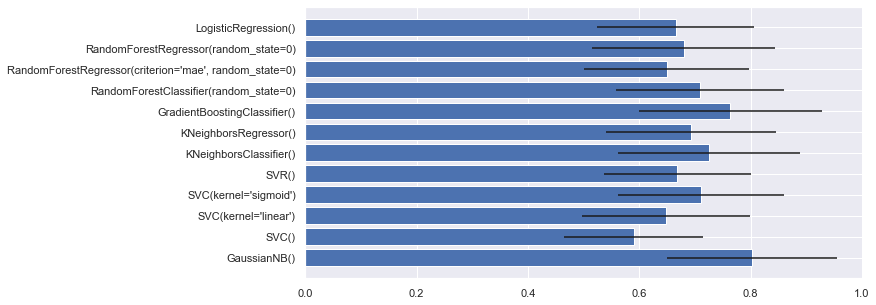

In [10]:
plt.figure(figsize=(10, 5))
plt.barh([str(i) for i in models], means, xerr=stds)
plt.show()

"Ящики с усами":

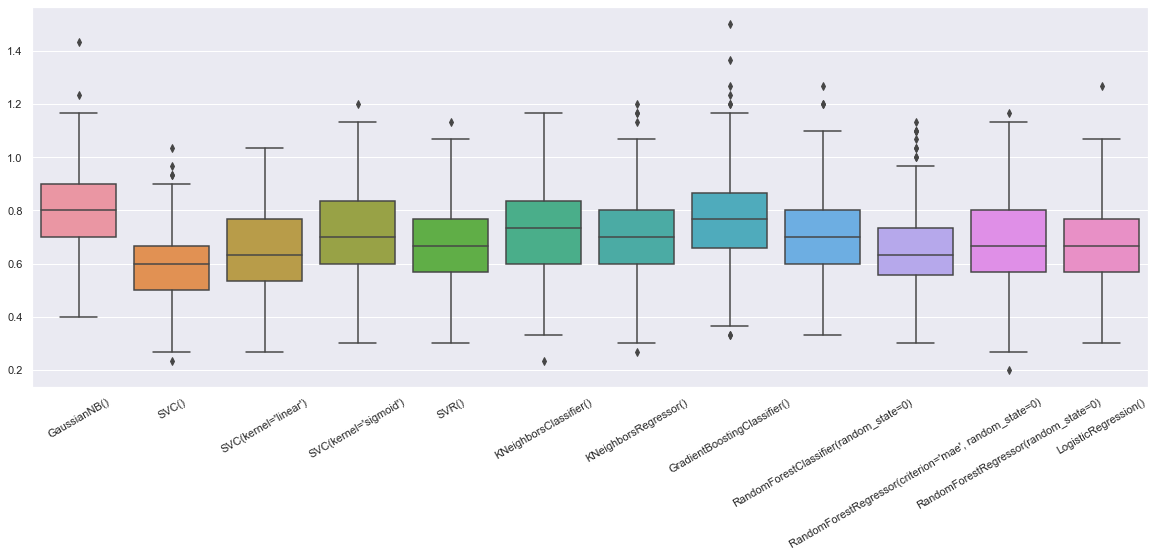

In [11]:
plt.figure(figsize=(20, 7))
ax = sns.boxplot(data=pd.DataFrame(scores, [str(i) for i in models]).T)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show()

Лучшие результаты по среднему качеству, ошибке и выбросам показывают модели SVC, RandomForestRegressor с округлением предсказаний до целых чисел и LogisticRegression. GradientBoostingClassifier, несмотря на то, что тоже в среднем работает неплохо, имеет больше случаев получения неудовлетворительного результата и ошибку как следствие.

Тестирование моделей на валидационной выборке:

In [12]:
model = RoundRegressor(RandomForestRegressor(random_state=0, criterion='mae')).fit(train_df, train_labels)
mean_absolute_error(model.predict(val_df), val_labels)

0.4666666666666667

In [13]:
model = SVC().fit(train_df, train_labels)
mean_absolute_error(model.predict(val_df), val_labels)

0.4222222222222222

In [15]:
model = LogisticRegression().fit(train_df, train_labels)
mean_absolute_error(model.predict(val_df), val_labels)

0.3333333333333333

### Ограничим максимальную глубину дерева, добавим больше деревьев

Повторно проведя эксперимент с другим разбиением на обучающую и валидационную выборки, мы пришли к выводу о зависимости итогового результата от изначального разбиения, которое будет проявляться даже при использовании сильных моделей из-за небольшого количества данных.

In [32]:
models = [
    RandomForestRegressor(random_state=0, criterion='mae'),
    RandomForestRegressor(random_state=0, criterion='mae', max_depth=5),
    RandomForestRegressor(random_state=0, criterion='mae', max_depth=10),
    RandomForestRegressor(random_state=0, criterion='mae', max_depth=15),
    RandomForestRegressor(random_state=0, criterion='mae', max_depth=20),
    RandomForestRegressor(random_state=0, criterion='mae', max_depth=30)
]

means = []
stds = []

for model in models:
    print(model, end=': ')
    rounded = bootstrap(RoundRegressor(model), X, y)
    means.append(rounded.mean())
    print(means[-1])
    stds.append(rounded.std())

RandomForestRegressor(criterion='mae', random_state=0): 0.5890666666666666
RandomForestRegressor(criterion='mae', max_depth=5, random_state=0): 0.5666666666666667
RandomForestRegressor(criterion='mae', max_depth=10, random_state=0): 0.588
RandomForestRegressor(criterion='mae', max_depth=15, random_state=0): 0.5773333333333333
RandomForestRegressor(criterion='mae', max_depth=20, random_state=0): 0.5756666666666668
RandomForestRegressor(criterion='mae', max_depth=30, random_state=0): 0.5865999999999999


### Подберём гиперпараметры логистической регрессии
Здесь был бы уместен поиск по сетке, однако ввиду ограничений по времени выполнение алгоритма будет времязатратным, поэтому просто рассмотрим несколько вариантов.

In [36]:
models = [
    LogisticRegression(tol=1e-4),
    LogisticRegression(tol=1e-5),
    LogisticRegression(tol=1e-3)
]

means = []
stds = []

for model in models:
    print(model, end=': ')
    rounded = bootstrap(RoundRegressor(model), X, y)
    means.append(rounded.mean())
    print(means[-1])
    stds.append(rounded.std())

LogisticRegression(): 0.6158666666666666
LogisticRegression(tol=1e-05): 0.6264666666666667
LogisticRegression(tol=0.001): 0.6223333333333333


In [41]:
models = [
    LogisticRegression(C=1),
    LogisticRegression(C=0.5),
    LogisticRegression(C=0.1),
    LogisticRegression(C=0.05)
]

means = []
stds = []

for model in models:
    print(model, end=': ')
    rounded = bootstrap(RoundRegressor(model), X, y)
    means.append(rounded.mean())
    print(means[-1])
    stds.append(rounded.std())

LogisticRegression(C=1): 0.6110666666666668
LogisticRegression(C=0.5): 0.6193333333333333
LogisticRegression(C=0.1): 0.6148666666666667
LogisticRegression(C=0.05): 0.6352000000000001


### Композиции алгоритмов
Так как используются классификаторы и регрессоры с округлением, применим VotingClassifier.

In [53]:
models = [VotingClassifier(estimators=[('lr',LogisticRegression()), ('svc', SVC()),
                                       ('rf', RoundClassifier(RandomForestRegressor(random_state=0, criterion='mae')))],
                           weights=w, n_jobs=-1) for w in [(2, 6, 2), (6, 2, 2), (2, 2, 6), (1, 1, 1)]]

means = []
stds = []

for model in models:
    print(model.weights, end=': ')
    rounded = bootstrap(model, X, y)
    means.append(rounded.mean())
    print(means[-1])
    stds.append(rounded.std())

(2, 6, 2): 0.5455333333333333
(6, 2, 2): 0.6292000000000001
(2, 2, 6): 0.5880666666666666
(1, 1, 1): 0.5304000000000001


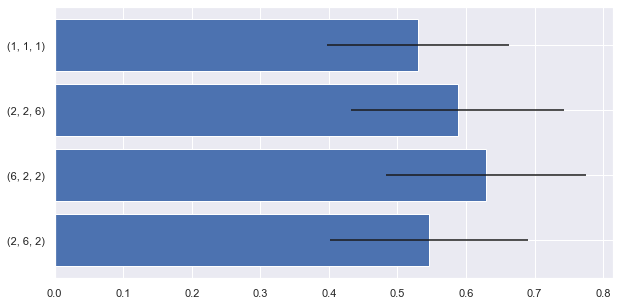

In [54]:
plt.figure(figsize=(10, 5))
plt.barh([str(i.weights) for i in models], means, xerr=stds)
plt.show()

Лучшее качество с наименьшим разбросом даёт голосование по трём моделям с равными весами. Проверка результата на валидации:

In [9]:
model = VotingClassifier(estimators=[('lr',LogisticRegression()), ('svc', SVC()),
                                     ('rf', RoundClassifier(RandomForestRegressor(random_state=0, criterion='mae')))])
model.fit(train_df, train_labels)
mean_absolute_error(model.predict(val_df), val_labels)

0.28888888888888886

Значение метрики на валидации также улучшилось.

### Метрики, основанные на табличных данных
Часть метрик была разработана исключительно для решения представленной задаче и основана на информации о расположении и форме овалов и прямоугольников. Эта информация может быть полезной для обучения.

Повторение предыдущих операций с учётом расстояний между объектами:

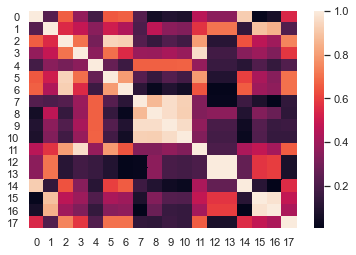

In [18]:
X = [
    make_dataframe(expert_train, train_data[0],
                   {'name': train_names, 'set': ['Expert', 'sample_1'], 'csv': 'DX_TEST_RESULT_FULL.csv'}),
    make_dataframe(expert_train, train_data[1],
                   {'name': train_names, 'set': ['Expert', 'sample_2'], 'csv': 'DX_TEST_RESULT_FULL.csv'}),
    make_dataframe(expert_train, train_data[2],
                   {'name': train_names, 'set': ['Expert', 'sample_3'], 'csv': 'DX_TEST_RESULT_FULL.csv'})
]

y = [
    train_label['Sample 1'],
    train_label['Sample 2'],
    train_label['Sample 3']
]

X_df = pd.concat(X)
X_df['label'] = np.concatenate(y)
X_df = StandardScaler().fit_transform(X_df)

sns.heatmap(pd.DataFrame(X_df).corr(method="spearman").abs())

for i in range(len(X)):
    X[i] = X[i].fillna(-1).to_numpy()

In [21]:
train_df = np.concatenate(X)

val_df = pd.concat([
    make_dataframe(expert_val, val_data[0],
                   {'name': train_names, 'set': ['Expert', 'sample_1'], 'csv': 'DX_TEST_RESULT_FULL.csv'}),
    make_dataframe(expert_val, val_data[1],
                   {'name': train_names, 'set': ['Expert', 'sample_2'], 'csv': 'DX_TEST_RESULT_FULL.csv'}),
    make_dataframe(expert_val, val_data[2],
                   {'name': train_names, 'set': ['Expert', 'sample_3'], 'csv': 'DX_TEST_RESULT_FULL.csv'})
]).fillna(-1).to_numpy()

scaler = StandardScaler()
train_df = scaler.fit_transform(train_df)
val_df = scaler.transform(val_df)

train_labels = np.concatenate(y)

val_labels = np.concatenate([
    val_label['Sample 1'],
    val_label['Sample 2'],
    val_label['Sample 3']
])

In [22]:
models = [
    GaussianNB(),
    SVC(),
    SVC(kernel='linear'),
    SVC(kernel='sigmoid'),
    SVR(),
    KNeighborsClassifier(),
    KNeighborsRegressor(),
    GradientBoostingClassifier(),
    RandomForestClassifier(random_state=0),
    RandomForestRegressor(random_state=0, criterion='mae'),
    RandomForestRegressor(random_state=0),
    LogisticRegression(),
]

means = []
stds = []
scores = []

for model in models:
    print(model, end=': ')
    rounded = bootstrap(RoundRegressor(model), X, y)
    scores.append(rounded)
    means.append(rounded.mean())
    print(means[-1])
    stds.append(rounded.std())

GaussianNB(): 0.7280666666666666
SVC(): 0.6186666666666666
SVC(kernel='linear'): 0.6592666666666667
SVC(kernel='sigmoid'): 0.7182000000000001
SVR(): 0.6363333333333333
KNeighborsClassifier(): 0.7197333333333333
KNeighborsRegressor(): 0.6431333333333333
GradientBoostingClassifier(): 0.7342
RandomForestClassifier(random_state=0): 0.687
RandomForestRegressor(criterion='mae', random_state=0): 0.6374666666666667
RandomForestRegressor(random_state=0): 0.6592666666666667
LogisticRegression(): 0.6587999999999999


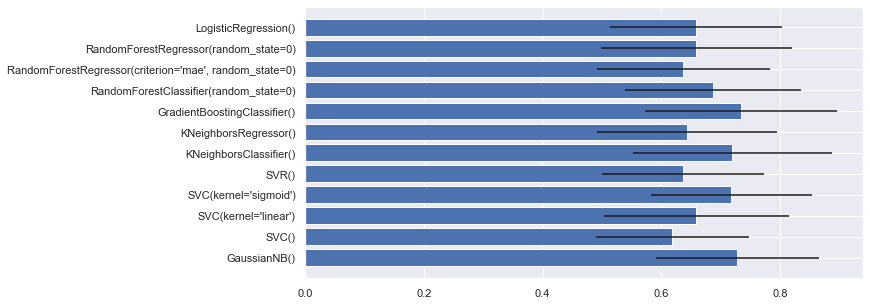

In [24]:
plt.figure(figsize=(10, 5))
plt.barh([str(i) for i in models], means, xerr=stds)
plt.show()

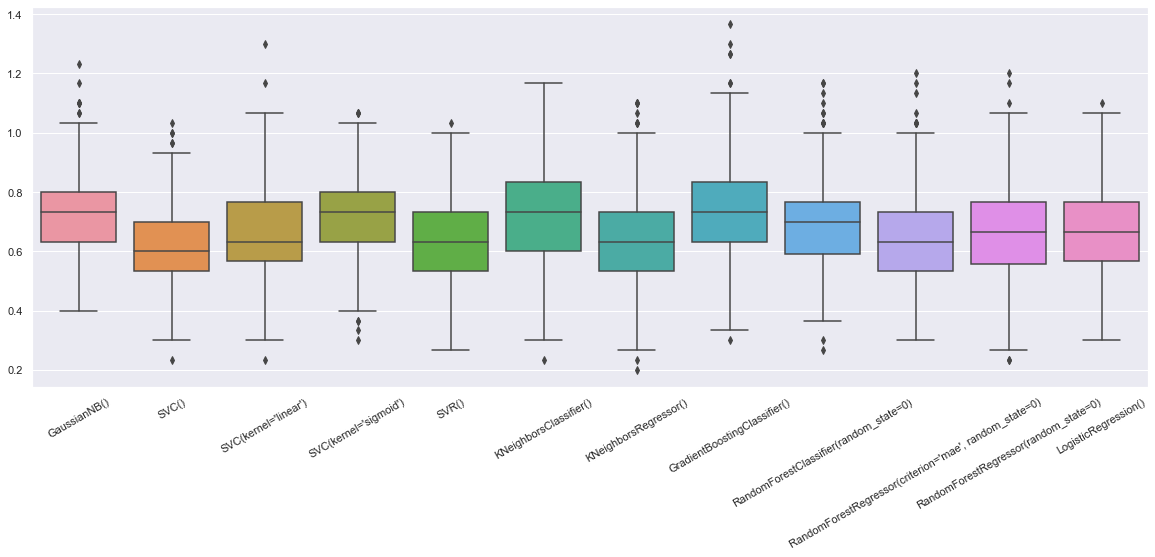

In [25]:
plt.figure(figsize=(20, 7))
ax = sns.boxplot(data=pd.DataFrame(scores, [str(i) for i in models]).T)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show()

Проверка на отложенной выборке:

In [26]:
model = RoundRegressor(RandomForestRegressor(random_state=0, criterion='mae')).fit(train_df, train_labels)
mean_absolute_error(model.predict(val_df), val_labels)

0.4888888888888889

In [27]:
model = LogisticRegression().fit(train_df, train_labels)
mean_absolute_error(model.predict(val_df), val_labels)

0.5111111111111111

Добавление новых метрик действительно сработало для улучшения качества некоторых алгоритмов. Но в финальном решении с целью не потерять качество на других видах разметки был добавлен вариант с предыдущим списком метрик.

## Идеи, не давшие улучшения результата и возможные причины

- Отбор признаков: их количество уже было достаточно мало.
- Применение свёрточной нейронной сети для получения предсказаний и извлечения признаков: ввиду специфики данных слишком сложные модели работают значительно хуже простых.
- Бустинги: ситуация аналогична ситуации с нейронными сетями.
- Аугментация изменением видов фигур: в некоторых тестовых случаях форма фигуры также влияет на экспертную оценку, метод добавил шум.

## Обучение модели на всём датасете, сохранение и предсказание

In [10]:
train_eval = pd.read_csv(DATA_PATH + '/OpenPart.csv')
test_eval = pd.read_csv(DATA_PATH + '/SecretPart_dummy.csv')

train_names = train_eval['Case'].to_numpy()
test_names = test_eval['Case'].to_numpy()

train_data = [
    load_data(train_names, DATA_PATH + '/sample_1', '_s1'),
    load_data(train_names, DATA_PATH + '/sample_2', '_s2'),
    load_data(train_names, DATA_PATH + '/sample_3', '_s3')
]

test_data = [
    load_data(test_names, DATA_PATH + '/sample_1', '_s1'),
    load_data(test_names, DATA_PATH + '/sample_2', '_s2'),
    load_data(test_names, DATA_PATH + '/sample_3', '_s3')
]

expert_train = load_data(train_names, DATA_PATH + '/expert', '_expert')
expert_test = load_data(test_names, DATA_PATH + '/expert', '_expert')

In [13]:
X = [
    make_dataframe(expert_train, train_data[0]),
    make_dataframe(expert_train, train_data[1]),
    make_dataframe(expert_train, train_data[2])
]

y = [
    train_eval['Sample 1'],
    train_eval['Sample 2'],
    train_eval['Sample 3']
]

for i in range(len(X)):
    X[i] = X[i].fillna(-1).to_numpy()

train_df = np.concatenate(X)

test_df = pd.concat([
    make_dataframe(expert_test, test_data[0]),
    make_dataframe(expert_test, test_data[1]),
    make_dataframe(expert_test, test_data[2])
]).fillna(-1).to_numpy()

scaler = StandardScaler()
train_df = scaler.fit_transform(train_df)
test_df = scaler.transform(test_df)

train_labels = np.concatenate(y)
test_labels = np.concatenate([
    test_eval['Sample 1'],
    test_eval['Sample 2'],
    test_eval['Sample 3']
])

In [14]:
model = VotingClassifier(estimators=[('lr',LogisticRegression()), ('svc', SVC()),
                                     ('rf', RoundClassifier(RandomForestRegressor(random_state=0, criterion='mae')))])
model.fit(train_df, train_labels)

In [41]:
predictions = model.predict(test_df).reshape((3, 40))
test_eval['Sample 1'] = predictions[0]
test_eval['Sample 2'] = predictions[1]
test_eval['Sample 3'] = predictions[2]
test_eval

,Case,Sample 1,Sample 2,Sample 3
0,00011827_003.png,1,1,1
1,00011925_072.png,5,5,3
2,00012045_019.png,1,5,1
3,00012094_040.png,5,3,2
4,00012174_000.png,5,3,3
5,00012270_005.png,3,3,5
6,00012414_000.png,3,1,1
7,00012592_005.png,4,4,2
8,00012829_004.png,3,5,5
9,00012892_010.png,3,2,3


In [42]:
test_eval.to_csv(PATH + "\\test_predictions.csv")

In [44]:
joblib.dump(model, PATH + "\\model\\model_dump.pkl")

['D:\\Documents\\GitHub\\medical-imaging-evaluation\\model\\model_dump.pkl']